<a href="https://colab.research.google.com/github/Patric/fkd-gs/blob/master/notebooks/FakeNewsDetectionGraphSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake news detection using graph solutions

This notebook is a walkthrough feature selection process and machine learning effects of Fake news detection using graph solution Master's Thesis.

# Code formatting
Use !black command once to format the code, then use F5 and then save. Uncomment when needed

In [1]:
# ! pip install black[jupyter]

In [2]:
# !black /content/drive/MyDrive/ColabNotebooks/FakeNewsDetectionGraphSolutions.ipynb

# Dataset loading

## Mount google drive with processed features and define dataset paths

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libs for operating on datasets

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from enum import Enum

### Set datasets paths variables

Warning!!! These are Colab based paths. As for now data should be saved to your google drive from https://drive.google.com/drive/folders/1HOEIyiiFBALoqrHN5Jh8RczkvMIgUVyH?usp=sharing
 Paths should be adjusted accordingly

In [27]:
# variable should be adjusted according to your google drive TODO: figure out how to bond datasets more simply
features_directory_path = "/content/drive/MyDrive/FakeNewsDetectonColabNotebooks/resources/features"

politifact_more_than_1_relation_path = (
    f"{features_directory_path}/politifact_more_than_1_relation/"
)
politifact_all_path = f"{features_directory_path}/politifact_all/"
gossipcop_path = f"{features_directory_path}/gossipcop/"

e13_followers_path = f"{features_directory_path}/MIB/E13/"
fsf_followers_path = f"{features_directory_path}/MIB/FSF/"
int_followers_path = f"{features_directory_path}/MIB/INT/"
twt_followers_path = f"{features_directory_path}/MIB/TWT/"
tfp_followers_path = f"{features_directory_path}/MIB/TFP/"

In [28]:
features_files_names = [
    "eigenvector_to_label.csv",
    "harmonic_closeness_to_label.csv",
    "hits_to_label.csv",
    "betweenness_to_label.csv",
    "closeness_to_label.csv",
    "page_rank_to_label.csv",
    "article_rank_to_label.csv",
    "degree_to_label.csv",
]

class FeatureColumnName(Enum):
  EIGENVECTOR = 'eigenvector_score'
  HARMONIC_CLOSENESS = 'harmonic_closeness_centrality'
  CLOSENESS = 'closeness_score'
  HITS_HUB = 'hits_hub'
  HITS_AUTH = 'hits_auth'
  BETWEENNESS = 'betweenness_score'
  PAGE_RANK = 'page_rank_score'
  ARTICLE_RANK = 'article_rank_score'
  OUT_DEGREE = 'outDegree'
  IN_DEGREE = 'inDegree'
  DEGREE = 'degree'

## Define util functions

In [5]:
def get_data_frame(*paths):
    paths = list(sum(paths, []))
    dfs = list(map(lambda path: pd.read_csv(path), paths))
    df = pd.concat(dfs, join="outer", axis=1)
    df = df.loc[:, ~df.columns.duplicated()].copy()
    return df


def get_feature_full_path(data_set_path, feature_data):
    return f"{data_set_path}{feature_data}"


def get_features_paths(data_set_path, features_files):
    return list(
        map(
            lambda feature_file: get_feature_full_path(data_set_path, feature_file),
            features_files,
        )
    )

In [6]:
# split into dependend and independent variables
def split_into_X_y(data_frame, dependent_variables_list, independend_variable):
  X = data_frame[dependent_variables_list]
  y = data_frame[independend_variable]

  return X, y

## Convert datasets to Pandas DataFrames

In [24]:
paths_array = [e13_followers_path, fsf_followers_path, int_followers_path, twt_followers_path, tfp_followers_path]
mib_combined = list(map(lambda dataset_path: get_data_frame(get_features_paths(dataset_path, features_files_names)), paths_array))
dfs_mib_combined = pd.concat(mib_combined)

In [8]:
df_politifact = get_data_frame(get_features_paths(politifact_all_path, features_files_names))
df_politifact_more_than_1_relation = get_data_frame(get_features_paths(politifact_more_than_1_relation_path, features_files_names))

df_gossipcop = get_data_frame(get_features_paths(gossipcop_path, features_files_names))

df_fake_news_net_skeleton_combined = pd.concat([df_politifact, df_gossipcop])

In [29]:
datasets = {
    'politifact': df_politifact,
    'gossipcop': df_gossipcop,
    'fake_news_skeleton_combined': df_fake_news_net_skeleton_combined,
    'mib_combined': dfs_mib_combined
}

# Feature selection


## Import libs for feature selection

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import seaborn as sns

## Define feature selection functions

In [11]:
def select_features_chi2(X_train, y_train, X_test, should_plot_output=False):
  # configure to select all features
  fs = SelectKBest(score_func=chi2, k='all')
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  for i in range(len(fs.scores_)):
      print('Feature %s: score: %f p_value: %f' % (fs.feature_names_in_[i], fs.scores_[i], fs.pvalues_[i]))

  # plot p_value
  if should_plot_output:
    plt.bar([i for i in range(len(fs.pvalues_))], fs.pvalues_)
    plt.show()

  return X_train_fs, X_test_fs, fs

In [12]:
def select_features_f(X_train, y_train, X_test, should_plot_output=False):
  # configure to select all features
  fs = SelectKBest(score_func=f_classif, k='all')
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  for i in range(len(fs.scores_)):
    print('Feature %s: score: %f p_value: %f' % (fs.feature_names_in_[i], fs.scores_[i], fs.pvalues_[i]))
  
  # plot p_value
  if should_plot_output:
    plt.bar([i for i in range(len(fs.pvalues_))], fs.pvalues_)
    plt.show()
    
  return X_train_fs, X_test_fs, fs

In [13]:
def select_features_mutual_info(X_train, y_train, X_test, should_plot_output=False):
  # configure to select all features
  fs = SelectKBest(score_func=mutual_info_classif, k='all')
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  for i in range(len(fs.scores_)):
    print('Feature %s: score: %f' % (fs.feature_names_in_[i], fs.scores_[i]))
  
  # plot p_value
  if should_plot_output:
    plt.bar([i for i in range(len(fs.pvalues_))], fs.pvalues_)
    plt.show()
    
  return X_train_fs, X_test_fs, fs

In [14]:
def select_features_r(X_train, y_train, X_test, should_plot_output=False):
  # configure to select all features
  fs = SelectKBest(score_func=r_regression, k='all')
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  for i in range(len(fs.scores_)):
    print('Feature %s: score: %f' % (fs.feature_names_in_[i], fs.scores_[i]))
  
  # plot p_value
  if should_plot_output:
    plt.bar([i for i in range(len(fs.pvalues_))], fs.pvalues_)
    plt.show()
  
  # TODO: checkout if X_train_fs, X_test_fs needed
  return X_train_fs, X_test_fs, fs

In [15]:
def tree_classifier(X_train, y_train, X_test):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X_train, y_train)
    print(clf.feature_importances_)

In [16]:
def plot_pearson_corr_matrix(data_frame):
  with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3):
    pd.options.display.float_format = '{:.3f}'.format
    print(data_frame.corr(method='pearson'))

In [43]:
def test_linear_regression_model(X_train, y_train, X_test, y_test):
  linreg=LinearRegression()
  linreg.fit(X_train,y_train)
  y_pred=linreg.predict(X_test)
  Accuracy=r2_score(y_test,y_pred)*100
  print(" Accuracy of the model is %.2f" %Accuracy)
  plt.scatter(y_test,y_pred)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()
  sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')
  plt.show()

## Test feature dependency

In [44]:
def test_feature_dependency_for_dataset(df):
  features_included = [
          FeatureColumnName.EIGENVECTOR.value,
          FeatureColumnName.HARMONIC_CLOSENESS.value,
          FeatureColumnName.HITS_HUB.value,
          FeatureColumnName.HITS_AUTH.value,
          FeatureColumnName.BETWEENNESS.value,
          FeatureColumnName.CLOSENESS.value,
          FeatureColumnName.PAGE_RANK.value,
          FeatureColumnName.OUT_DEGREE.value,
          FeatureColumnName.IN_DEGREE.value,
          FeatureColumnName.DEGREE.value
          ]
  
  label_column_name = 'user.label'
  X, y = split_into_X_y(df, features_included, label_column_name)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

  print('Mutual Info')
  select_features_mutual_info(X_train, y_train, X_test)
  print('Mutual f classif (F-test)')
  select_features_f(X_train, y_train, X_test)
  print('Chi2')
  select_features_chi2(X_train, y_train, X_test)
  print('Pearson')
  select_features_r(X_train, y_train, X_test)
  print('Tree classifier')
  tree_classifier(X_train, y_train, X_test)
  print(f'Linear regression of features: {features_included}')
  test_linear_regression_model(X_train, y_train, X_test, y_test)

Testing feature dependency for: politifact
Mutual Info
Feature eigenvector_score: score: 0.004280
Feature harmonic_closeness_centrality: score: 0.000625
Feature hits_hub: score: 0.000033
Feature hits_auth: score: 0.027067
Feature betweenness_score: score: 0.001819
Feature closeness_score: score: 0.000000
Feature page_rank_score: score: 0.561412
Feature outDegree: score: 0.000916
Feature inDegree: score: 0.003727
Feature degree: score: 0.000000
Mutual f classif (F-test)
Feature eigenvector_score: score: 7.036309 p_value: 0.007991
Feature harmonic_closeness_centrality: score: 0.011918 p_value: 0.913069
Feature hits_hub: score: 1.271085 p_value: 0.259571
Feature hits_auth: score: 554.167899 p_value: 0.000000
Feature betweenness_score: score: 1.785008 p_value: 0.181544
Feature closeness_score: score: 0.625160 p_value: 0.429141
Feature page_rank_score: score: 1.294843 p_value: 0.255165
Feature outDegree: score: 1.484955 p_value: 0.223009
Feature inDegree: score: 1.376784 p_value: 0.240657
F

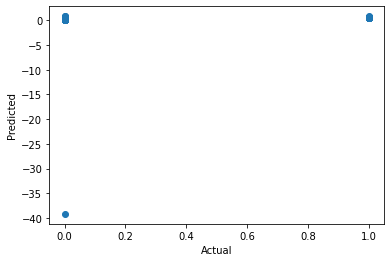

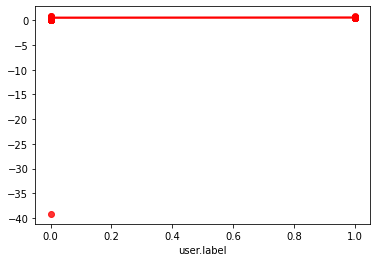

Testing feature dependency for: gossipcop
Mutual Info
Feature eigenvector_score: score: 0.010301
Feature harmonic_closeness_centrality: score: 0.009920
Feature hits_hub: score: 0.000279
Feature hits_auth: score: 0.012191
Feature betweenness_score: score: 0.010754
Feature closeness_score: score: 0.010235
Feature page_rank_score: score: 0.207060
Feature outDegree: score: 0.014397
Feature inDegree: score: 0.038859
Feature degree: score: 0.030771
Mutual f classif (F-test)
Feature eigenvector_score: score: 11.669539 p_value: 0.000635
Feature harmonic_closeness_centrality: score: 2679.003422 p_value: 0.000000
Feature hits_hub: score: 1.470801 p_value: 0.225220
Feature hits_auth: score: 256.134608 p_value: 0.000000
Feature betweenness_score: score: 403.181013 p_value: 0.000000
Feature closeness_score: score: 1473.157317 p_value: 0.000000
Feature page_rank_score: score: 9692.255471 p_value: 0.000000
Feature outDegree: score: 0.169242 p_value: 0.680787
Feature inDegree: score: 596.865622 p_valu

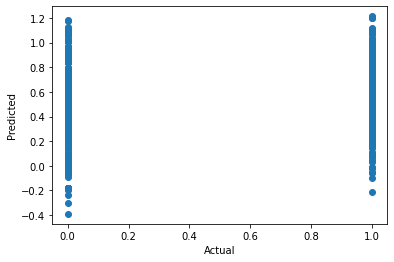

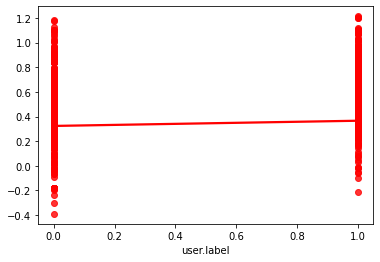

Testing feature dependency for: fake_news_skeleton_combined
Mutual Info
Feature eigenvector_score: score: 0.017907
Feature harmonic_closeness_centrality: score: 0.019678
Feature hits_hub: score: 0.000000
Feature hits_auth: score: 0.012085
Feature betweenness_score: score: 0.007788
Feature closeness_score: score: 0.018974
Feature page_rank_score: score: 0.224156
Feature outDegree: score: 0.011090
Feature inDegree: score: 0.041724
Feature degree: score: 0.028556
Mutual f classif (F-test)
Feature eigenvector_score: score: 0.553632 p_value: 0.456838
Feature harmonic_closeness_centrality: score: 7220.831897 p_value: 0.000000
Feature hits_hub: score: 1.647410 p_value: 0.199313
Feature hits_auth: score: 515.474944 p_value: 0.000000
Feature betweenness_score: score: 377.558168 p_value: 0.000000
Feature closeness_score: score: 7356.961837 p_value: 0.000000
Feature page_rank_score: score: 8766.009272 p_value: 0.000000
Feature outDegree: score: 0.184072 p_value: 0.667897
Feature inDegree: score: 

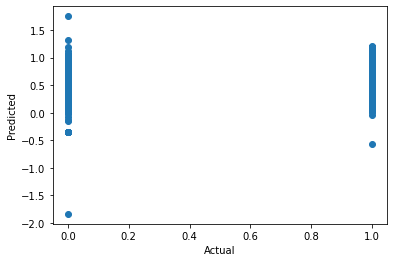

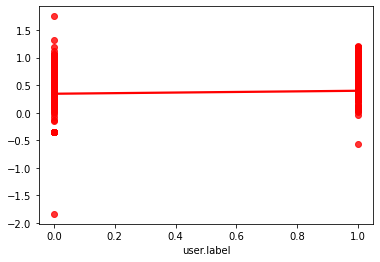

Testing feature dependency for: mib_combined
Mutual Info


In [ ]:
for dataset_name in datasets:
  print(f'Testing feature dependency for: {dataset_name}')
  test_feature_dependency_for_dataset(datasets[dataset_name])

# Classifiers testing

## Import libs for classifiers testing

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold

## Test classifiers functions

In [10]:
def test_classfiers(classifiers, X_train, X_test, y_train, y_test):
  log_cols = ["Classifier", "Accuracy", "Log Loss"]
  log = pd.DataFrame(columns=log_cols)

  for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("=" * 30)
    print(name)

    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc * 100, ll]], columns=log_cols)
    log = log.append(log_entry)

  print("=" * 30)

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(df_fake_news_net_skeleton_combined, features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 77.9889%
Log Loss: 3.0770044259677074


In [ ]:
classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

# Markup helper TODO: delete


Markdown | Preview
--- | ---
`**bold text**` | **bold text**
`*italicized text*` or `_italicized text_` | *italicized text*
`` `Monospace` `` | `Monospace`
`~~strikethrough~~` | ~~strikethrough~~
`[A link](https://www.google.com)` | [A link](https://www.google.com)
`![An image](https://www.google.com/images/rss.png)` | ![An image](https://www.google.com/images/rss.png)


---
Headings are rendered as titles.

```markdown
# Section 1
# Section 2
## Sub-section under Section 2
### Sub-section under the sub-section under Section 2
# Section 3
```

# Section 1
# Section 2
## Sub-section under Section 2
### Sub-section under the sub-section under Section 2
# Section 3

The table of contents, available on the left side of Colab, is populated using at most one section title from each text cell.

---

```markdown
>One level of indentation
```

>One level of indentation


```markdown
>>Two levels of indentation
```

>>Two levels of indentation

---

Code blocks

````
```python
print("a")
```
````

```python
print("a")
```

---

Ordered lists:
```markdown
1. One
1. Two
1. Three
```
1. One
1. Two
1. Three

---

Unordered lists:
```markdown
* One
* Two
* Three
```
* One
* Two
* Three

---

Equations:

```markdown
$y=x^2$

$e^{i\pi} + 1 = 0$

$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$

$\frac{n!}{k!(n-k)!} = {n \choose k}$

$A_{m,n} =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{m,1} & a_{m,2} & \cdots & a_{m,n}
 \end{pmatrix}$
```

$y=x^2$

$e^{i\pi} + 1 = 0$

$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$

$\frac{n!}{k!(n-k)!} = {n \choose k}$

$A_{m,n} =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{m,1} & a_{m,2} & \cdots & a_{m,n}
 \end{pmatrix}$


 ---

Tables:
```markdown
First column name  | Second column name 
-------------------|------------------
Row 1, Col 1       | Row 1, Col 2 
Row 2, Col 1       | Row 2, Col 2 

```

First column name  | Second column name 
-------------------|------------------
Row 1, Col 1       | Row 1, Col 2 
Row 2, Col 1       | Row 2, Col 2 

---

Horizontal rules:
```markdown
---
```

---




## Differences between Colab Markdown and other Markdown dialects

Colab uses [marked.js](https://github.com/chjj/marked) and so is similar but not quite identical to the Markdown used by Jupyter and Github.

Colab supports (MathJax) $\LaTeX$ equations like Jupyter, but does not allow HTML tags in the Markdown. Colab does not support some GitHub additions like emojis and to-do checkboxes.

If HTML must be included in a Colab notebook, see the [%%html magic](/notebooks/basic_features_overview.ipynb#scrollTo=qM4myQGfQboQ).

## Useful references

* [Github Markdown basics](https://help.github.com/articles/markdown-basics/)
* [Github flavored Markdown](https://help.github.com/articles/github-flavored-markdown/)
* [Original Markdown spec: Syntax](http://daringfireball.net/projects/markdown/syntax)
* [Original Markdown spec: Basics](http://daringfireball.net/projects/markdown/basics)
* [marked.js library used by Colab](https://github.com/chjj/marked)
* [LaTex mathematics for equations](https://en.wikibooks.org/wiki/LaTeX/Mathematics)